In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from matplotlib import pyplot as plt

# ------------------------------------------------------------------- #
!git clone https://github.com/anthony-wang/CrabNet.git
%cd CrabNet
!pip install -e
!ls crabnet
!grep -rnw 'crabnet' -e 'class CrabNet'
from crabnet.kingcrab import CrabNet

Cloning into 'CrabNet'...
remote: Enumerating objects: 3190, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 3190 (delta 1), reused 1 (delta 1), pack-reused 3188 (from 3)
Receiving objects: 100% (3190/3190), 438.40 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (791/791), done.
Updating files: 100% (1283/1283), done.
/content/CrabNet

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument
kingcrab.py  model.py
crabnet/kingcrab.py:194:class CrabNet(nn.Module):


In [2]:
# 📥 1. 데이터 로딩 및 필터링
df = pd.read_excel('/content/estm.xlsx')
df1 = df[(df['temperature(K)'] > 100) & (df['temperature(K)'] < 350)].copy()
print(df.columns)

Index(['Formula', 'temperature(K)', 'seebeck_coefficient(μV/K)',
       'electrical_conductivity(S/m)', 'thermal_conductivity(W/mK)',
       'power_factor(W/mK2)', 'ZT', 'reference'],
      dtype='object')


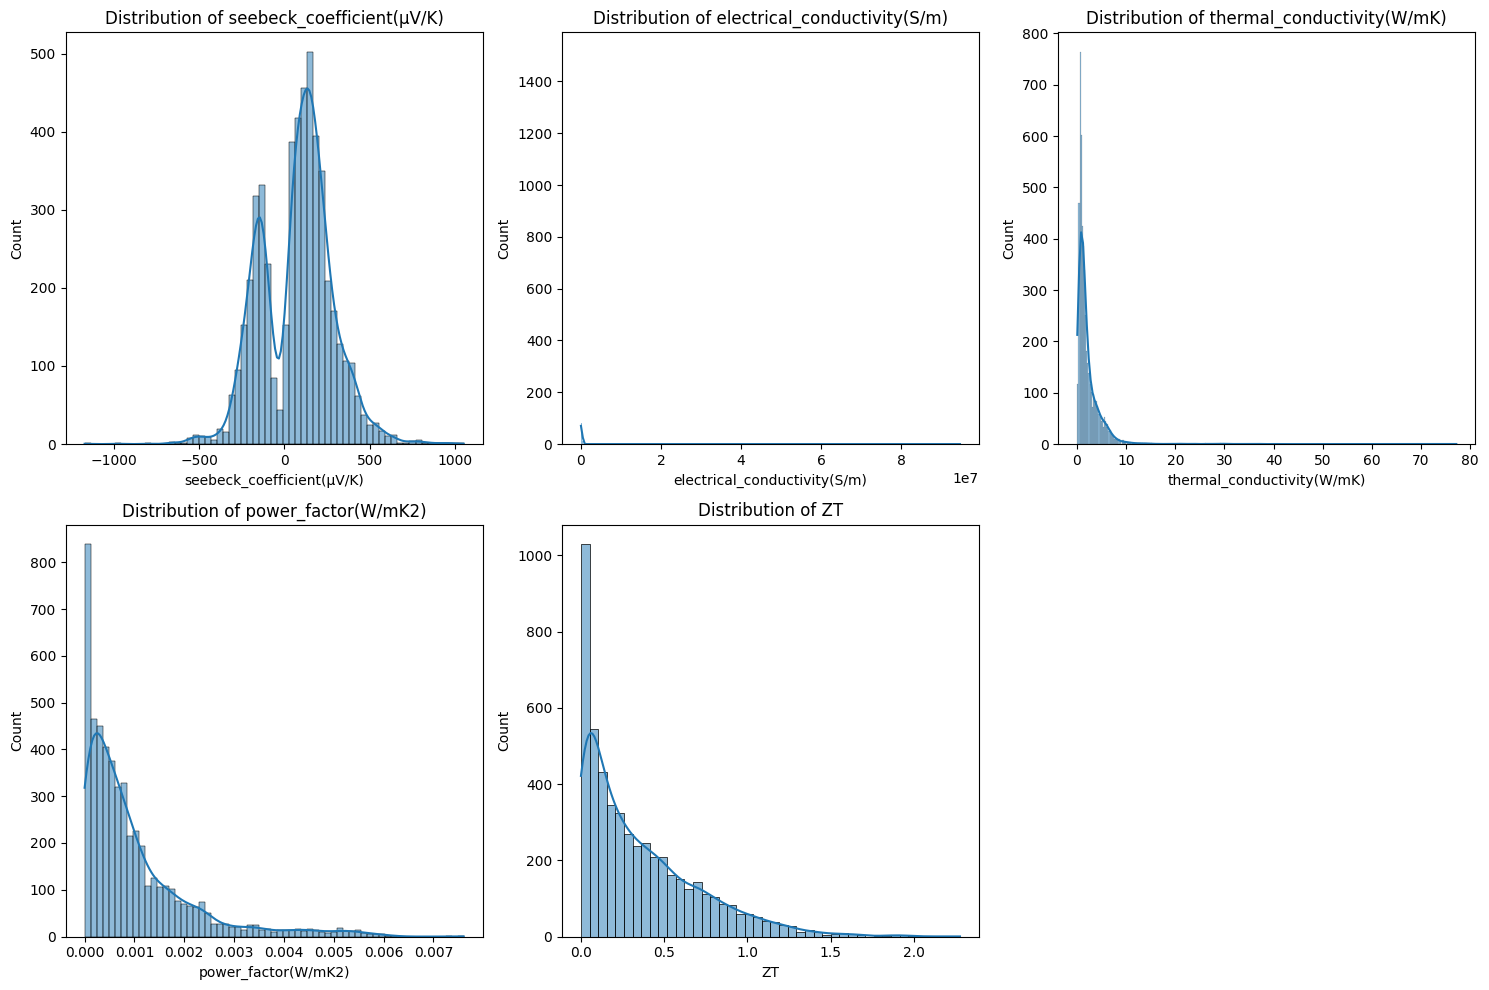

▶ 기본 통계
       seebeck_coefficient(μV/K)  electrical_conductivity(S/m)  \
count                 826.000000                  8.260000e+02   
mean                   50.175233                  1.285460e+05   
std                   201.633982                  3.223300e+05   
min                  -666.670000                  4.259000e-04   
25%                   -91.675000                  6.329500e+03   
50%                    54.415000                  4.103950e+04   
75%                   152.260000                  1.258515e+05   
max                   774.260000                  6.740000e+06   

       thermal_conductivity(W/mK)  power_factor(W/mK2)            ZT  
count                  826.000000         8.260000e+02  8.260000e+02  
mean                     2.727551         7.759138e-04  1.489195e-01  
std                      4.004042         9.708209e-04  1.924839e-01  
min                      0.070000         6.489239e-11  1.030443e-08  
25%                      0.781475         

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 2. 분포 확인할 열 선택
columns_to_check = ['seebeck_coefficient(μV/K)', 'electrical_conductivity(S/m)',
                    'thermal_conductivity(W/mK)', 'power_factor(W/mK2)', 'ZT']

# 3. 분포 시각화
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# 4. 정규화 필요성 판단을 위한 기초 통계
print("▶ 기본 통계")
print(df1[columns_to_check].describe())

▶ 정규화 결과
       seebeck_coefficient(μV/K)  electrical_conductivity(S/m)  \
count               8.260000e+02                    826.000000   
mean               -8.602212e-18                      0.633867   
std                 1.000606e+00                      0.170999   
min                -3.557335e+00                      0.000000   
25%                -7.039298e-01                      0.556670   
50%                 2.103978e-02                      0.675555   
75%                 5.065943e-01                      0.746825   
max                 3.593261e+00                      1.000000   

       thermal_conductivity(W/mK)  power_factor(W/mK2)          ZT  
count                  826.000000           826.000000  826.000000  
mean                     0.240840             0.134961    0.164241  
std                      0.151260             0.168720    0.190272  
min                      0.000000             0.000000    0.000000  
25%                      0.122440             0.023

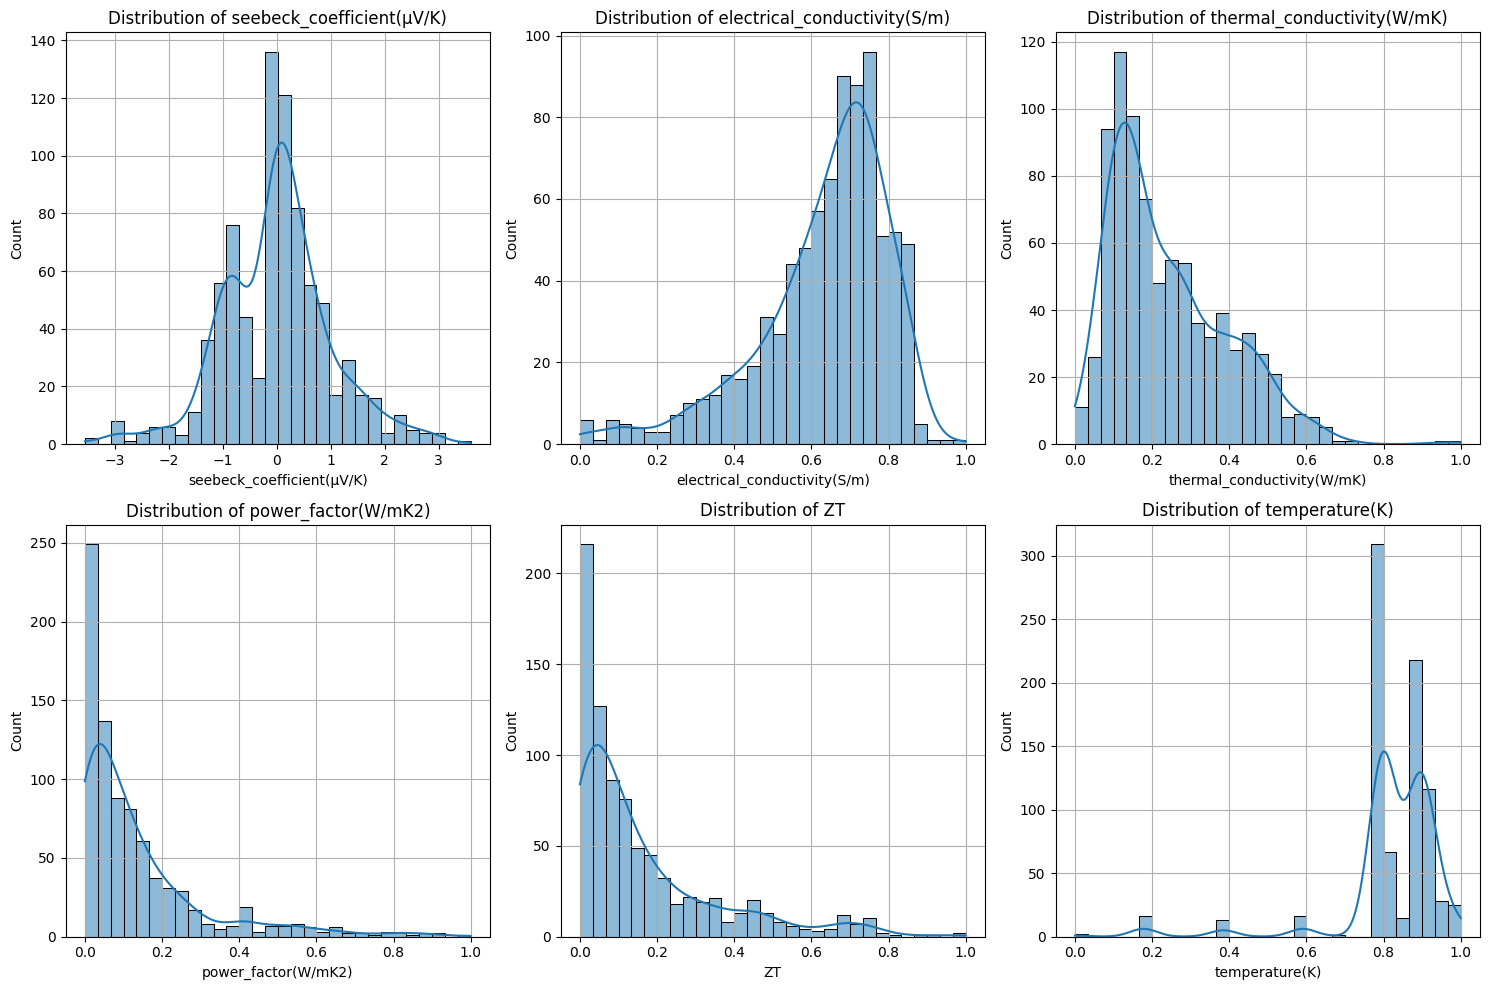

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# ✅ 원본 복사해서 새로운 DataFrame 생성
df_norm = df1.copy()

# 🔧 정규화 대상 열
cols_to_normalize = [
    'seebeck_coefficient(μV/K)',
    'electrical_conductivity(S/m)',
    'thermal_conductivity(W/mK)',
    'power_factor(W/mK2)',
    'ZT',
    'temperature(K)'  # ⬅️ 온도도 포함
]

# 🔹 log1p + MinMax 정규화할 열
log_minmax_cols = [
    'electrical_conductivity(S/m)',
    'thermal_conductivity(W/mK)',
    'power_factor(W/mK2)',
    'ZT'
]

# 🔹 log1p + MinMax 정규화 적용
for col in log_minmax_cols:
    log_col = f"{col}_log"
    norm_col = col  # 덮어쓰기
    df_norm[log_col] = np.log1p(df1[col])  # 로그 버전 보존 (선택적)
    df_norm[norm_col] = MinMaxScaler().fit_transform(df_norm[[log_col]])

# 🔸 표준화할 열 (Seebeck 계수 등)
standard_cols = list(set(cols_to_normalize) - set(log_minmax_cols) - {'temperature(K)'})
scaler_std = StandardScaler()
df_norm[standard_cols] = scaler_std.fit_transform(df_norm[standard_cols])

# 🔸 온도 정규화 (MinMax 0~1 범위)
scaler_temp = MinMaxScaler()
df_norm['temperature(K)'] = scaler_temp.fit_transform(df1[['temperature(K)']])

# ✅ 정규화 완료된 값 요약
print("▶ 정규화 결과")
print(df_norm[columns_to_check].describe())

# 정규화된 열들
cols_to_plot = [
    'seebeck_coefficient(μV/K)',
    'electrical_conductivity(S/m)',
    'thermal_conductivity(W/mK)',
    'power_factor(W/mK2)',
    'ZT',
    'temperature(K)'
]

# 서브플롯 설정
plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_norm[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------- #

In [15]:
df_norm = df_norm.sample(frac=1)

df_train = df_norm[:600].copy()
df_test = df_norm[600:].copy()

In [18]:
!pip install pymatgen
import torch
from torch.utils.data import Dataset
from pymatgen.core import Composition
import numpy as np

class FormulaDataset(Dataset):
    def __init__(self, df, formula_col="Formula", target_col=None, max_len=8):
        self.formulas = df[formula_col].values
        self.targets = df[target_col].values if target_col and target_col in df.columns else None
        self.temperatures = df["temperature(K)"].values  # 온도 열 고정
        self.max_len = max_len

        # 원소 리스트 정의 (padding 0, index 1부터 시작)
        self.element_list = [
            "H",  "He", "Li", "Be", "B",  "C",  "N",  "O",  "F",  "Ne",
            "Na", "Mg", "Al", "Si", "P",  "S",  "Cl", "Ar", "K",  "Ca",
            "Sc", "Ti", "V",  "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
            "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y",  "Zr",
            "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
            "Sb", "Te", "I",  "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
            "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
            "Lu", "Hf", "Ta", "W",  "Re", "Os", "Ir", "Pt", "Au", "Hg",
            "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
            "Pa", "U",  "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
            "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
            "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
        ]
        self.element_to_idx = {el: i + 1 for i, el in enumerate(self.element_list)}  # 0: padding

    def __len__(self):
        return len(self.formulas)

    def __getitem__(self, idx):
        formula = self.formulas[idx]
        try:
            elem_tensor, frac_tensor = self.formula_to_tensor(formula)
        except Exception as e:
            raise ValueError(f"[Error parsing formula '{formula}']: {e}")

        temperature = torch.tensor(self.temperatures[idx], dtype=torch.float32).unsqueeze(0)  # shape: [1]

        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.float32)
            return elem_tensor, frac_tensor, temperature, target
        else:
            return elem_tensor, frac_tensor, temperature

    def formula_to_tensor(self, formula):
        try:
            comp = Composition(formula).fractional_composition
        except Exception as e:
            raise ValueError(f"Failed to parse chemical formula '{formula}': {e}")

        elements = [str(el) for el in comp.keys()]
        fractions = list(comp.values())

        if len(elements) > self.max_len:
            raise ValueError(f"Formula '{formula}' has {len(elements)} elements; max_len={self.max_len}")

        elem_tensor = torch.zeros(self.max_len, dtype=torch.long)
        frac_tensor = torch.zeros(self.max_len, dtype=torch.float32)

        for i, el_symbol in enumerate(elements):
            if el_symbol not in self.element_to_idx:
                raise ValueError(f"Unknown element symbol: '{el_symbol}' in formula '{formula}'")
            elem_tensor[i] = self.element_to_idx[el_symbol]
            frac_tensor[i] = float(fractions[i])

        return elem_tensor, frac_tensor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 45.8 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=3221aca41f0cc4377777adaa6e338a38a612912849345d73748c5119d2770a03
  Stored in directory: /root/.cache/pip/wheels/16/fb/76/306387739cf9d53b1c39b0c8aadbbb17dc05f256756d8fd915
Successfully built bibtexparser


In [20]:
# FormulaDataset 객체 생성 (온도 포함 버전)
dataset = FormulaDataset(df_train, formula_col='Formula', target_col='electrical_conductivity(S/m)')

# 몇 개만 출력해서 확인
for i in range(5):
    elem_tensor, frac_tensor, temp_tensor, target = dataset[i]
    print(f"🔹 Sample {i}")
    print("Element indices:", elem_tensor)
    print("Fractions      :", frac_tensor)
    print("Temperature    :", temp_tensor)
    print("Target         :", target)
    print("-" * 40)


🔹 Sample 0
Element indices: tensor([22, 13,  8,  0,  0,  0,  0,  0])
Fractions      : tensor([0.3267, 0.0067, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Temperature    : tensor([0.7810])
Target         : tensor(0.4831)
----------------------------------------
🔹 Sample 1
Element indices: tensor([47, 83, 82, 51, 34,  0,  0,  0])
Fractions      : tensor([0.2500, 0.1488, 0.0262, 0.0750, 0.5000, 0.0000, 0.0000, 0.0000])
Temperature    : tensor([0.9050])
Target         : tensor(0.4075)
----------------------------------------
🔹 Sample 2
Element indices: tensor([51, 32, 52,  0,  0,  0,  0,  0])
Fractions      : tensor([0.0750, 0.4250, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Temperature    : tensor([0.8926])
Target         : tensor(0.6360)
----------------------------------------
🔹 Sample 3
Element indices: tensor([19, 56, 31, 51,  0,  0,  0,  0])
Fractions      : tensor([0.1633, 0.0033, 0.1667, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000])
Temperature    : tensor([0.8967])
Target   

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy

def fit(model, train_set, test_set, criterion, epochs=300, lr=1e-4, patience=20):
    device = model.compute_device
    model.to(device)
    model.train()

    # 입력 텐서 준비 (elem, frac, temp, target)
    src_train = torch.stack([s for s, _, _, _ in train_set]).to(device)
    frac_train = torch.stack([f for _, f, _, _ in train_set]).to(device)
    temp_train = torch.stack([t for _, _, t, _ in train_set]).unsqueeze(1).to(device)
    y_train = torch.stack([y for _, _, _, y in train_set]).float().to(device)

    src_test = torch.stack([s for s, _, _, _ in test_set]).to(device)
    frac_test = torch.stack([f for _, f, _, _ in test_set]).to(device)
    temp_test = torch.stack([t for _, _, t, _ in test_set]).unsqueeze(1).to(device)
    y_test = torch.stack([y for _, _, _, y in test_set]).float().to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_mae = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    train_mae_list, val_mae_list = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        output = model(src_train, frac_train, temp_train)
        if isinstance(output, tuple): output = output[0]

        if output.ndim >= 2 and output.shape[1] >= 2:
            pred_train, _ = output.chunk(2, dim=1)
        else:
            pred_train = output

        y_pred = pred_train.squeeze(-1)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # 검증
        model.eval()
        with torch.no_grad():
            val_out = model(src_test, frac_test, temp_test)
            if isinstance(val_out, tuple): val_out = val_out[0]

            if val_out.ndim >= 2 and val_out.shape[1] >= 2:
                pred_test, _ = val_out.chunk(2, dim=1)
            else:
                pred_test = val_out

            y_val = pred_test.squeeze(-1)

        train_mae = torch.mean(torch.abs(y_pred - y_train)).item()
        val_mae = torch.mean(torch.abs(y_val - y_test)).item()
        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)

        if epoch % 10 == 0 or epoch == 1:
            print(f"📊 Epoch {epoch}/{epochs} - Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

        if val_mae < best_val_mae - 1e-4:
            best_val_mae = val_mae
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

    # 최적 모델 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 최종 예측 + 불확실성 추출
    model.eval()
    with torch.no_grad():
        train_out = model(src_train, frac_train, temp_train)
        test_out = model(src_test, frac_test, temp_test)
        if isinstance(train_out, tuple): train_out = train_out[0]
        if isinstance(test_out, tuple): test_out = test_out[0]

        if train_out.ndim >= 2 and train_out.shape[1] >= 2:
            pred_train, logvar_train = train_out.chunk(2, dim=1)
            sigma_train = logvar_train.exp().sqrt()
        else:
            pred_train = train_out
            sigma_train = torch.zeros_like(pred_train)

        if test_out.ndim >= 2 and test_out.shape[1] >= 2:
            pred_test, logvar_test = test_out.chunk(2, dim=1)
            sigma_test = logvar_test.exp().sqrt()
        else:
            pred_test = test_out
            sigma_test = torch.zeros_like(pred_test)

    return (
        pred_train.squeeze(-1).cpu().numpy(),
        sigma_train.squeeze(-1).cpu().numpy(),
        pred_test.squeeze(-1).cpu().numpy(),
        sigma_test.squeeze(-1).cpu().numpy(),
        y_train.cpu().numpy(),
        y_test.cpu().numpy()
    )


In [22]:
import torch
import torch.nn as nn

class PatchedCrabNet(nn.Module):
    def __init__(self, out_dims=2, d_model=512, heads=4, compute_device=torch.device("cpu"), residual_nn="roost"):
        super().__init__()
        self.compute_device = compute_device
        self.d_model = d_model

        # 임베딩: element index → d_model vector
        self.embedding = nn.Embedding(119, d_model, padding_idx=0)  # 118개 원소 + padding

        # Self-attention transformer 인코더
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Roost-style residual network (element-wise 평균 이후 global + temp)
        if residual_nn == "roost":
            self.residual_nn = nn.Sequential(
                nn.Linear(d_model + 1, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, out_dims)  # 예측값 + log(sigma^2) 출력
            )
        else:
            self.residual_nn = nn.Sequential(
                nn.Linear(d_model + 1, out_dims)
            )

    def forward(self, elem_tensor, frac_tensor, temp_tensor):
        # [batch, max_len] → [batch, max_len, d_model]
        x = self.embedding(elem_tensor)

        # 조성 정보 반영 (간단히 scaling)
        x = x * frac_tensor.unsqueeze(-1)  # [batch, max_len, d_model]

        # transformer 인코더 → [batch, max_len, d_model]
        x = self.encoder(x)

        # global context → 평균 풀링
        x = x.mean(dim=1)  # [batch, d_model]

        # 온도 차원 정리 후 concat
        if temp_tensor.dim() == 1:
            temp_tensor = temp_tensor.unsqueeze(1)  # [batch, 1]
        elif temp_tensor.dim() == 3:
            temp_tensor = temp_tensor.squeeze(-1)  # [batch, 1]

        x = torch.cat([x, temp_tensor], dim=-1)  # [batch, d_model + 1]

        # Roost-style residual NN
        out = self.residual_nn(x)  # [batch, out_dims]
        return out

In [23]:
# 테스트용 데이터 (배치 크기 = 2, 원소 최대 8개)
elem_tensor = torch.tensor([
    [49, 50, 0, 0, 0, 0, 0, 0],  # 예: In, Sn
    [51, 52, 0, 0, 0, 0, 0, 0]   # 예: Sb, Te
])  # [2, 8]

frac_tensor = torch.tensor([
    [0.5, 0.5, 0, 0, 0, 0, 0, 0],
    [0.4, 0.6, 0, 0, 0, 0, 0, 0]
])  # [2, 8]

temp_tensor = torch.tensor([0.6, 0.8])  # 정규화된 온도 [2] → 자동 처리됨

# 모델 초기화
model = PatchedCrabNet(out_dims=2)
model.eval()

# forward
with torch.no_grad():
    output = model(elem_tensor, frac_tensor, temp_tensor)

print("예측 출력값:", output)


예측 출력값: tensor([[ 0.0460, -0.0271],
        [ 0.0976, -0.0288]])


In [47]:
import torch
import torch.nn as nn
import pandas as pd
import pickle
import os

results = {}

# ✅ 저장 경로 설정
save_dir = "/content/crabnet_outputs"
os.makedirs(save_dir, exist_ok=True)

for prop in ['seebeck_coefficient(μV/K)', 'electrical_conductivity(S/m)', 'thermal_conductivity(W/mK)']:
    print(f"▶ Training for: {prop}")

    cb = PatchedCrabNet(
        out_dims=2,
        d_model=512,
        heads=4,
        compute_device=torch.device("cpu"),
        residual_nn="roost"
    )

    # ✅ 온도 포함된 데이터셋 구성
    train_set = [sample for sample in FormulaDataset(df_train, formula_col='Formula', target_col=prop)]
    test_set  = [sample for sample in FormulaDataset(df_test,  formula_col='Formula', target_col=prop)]

    # ✅ 학습 (온도 포함)
    train_pred, train_sigma, test_pred, test_sigma, y_train, y_test = fit(
        cb, train_set, test_set,
        criterion=nn.HuberLoss(), epochs=300, lr=1e-4, patience=20
    )

    # ✅ 결과 저장
    results[prop] = {
        'train_pred' : train_pred,
        'train_sigma': train_sigma,
        'test_pred'  : test_pred,
        'test_sigma' : test_sigma,
        'y_train'    : y_train,
        'y_test'     : y_test,
        'model'      : cb
    }

    # ✅ 예측 결과 → CSV로 저장
    df_out = pd.DataFrame({
        'True': y_test,
        'Predicted': test_pred,
        'Sigma': test_sigma
    })
    filename = f"{save_dir}/prediction_{prop.replace('/', '_')}.csv"
    df_out.to_csv(filename, index=False)
    print(f"📁 저장 완료: {filename}")

# ✅ 전체 results 객체도 pickle로 저장
with open(f"{save_dir}/results_crabnet_with_temp.pkl", "wb") as f:
    pickle.dump(results, f)
print(f"✅ 전체 results 객체 저장 완료: {save_dir}/results_crabnet_with_temp.pkl")


▶ Training for: seebeck_coefficient(μV/K)
📊 Epoch 1/300 - Train MAE: 0.7555, Val MAE: 0.6375
📊 Epoch 10/300 - Train MAE: 0.5637, Val MAE: 0.4428
📊 Epoch 20/300 - Train MAE: 0.4405, Val MAE: 0.3857
📊 Epoch 30/300 - Train MAE: 0.3662, Val MAE: 0.3595
📊 Epoch 40/300 - Train MAE: 0.3340, Val MAE: 0.3443
📊 Epoch 50/300 - Train MAE: 0.2842, Val MAE: 0.3502
📊 Epoch 60/300 - Train MAE: 0.2652, Val MAE: 0.3103
📊 Epoch 70/300 - Train MAE: 0.2637, Val MAE: 0.2991
📊 Epoch 80/300 - Train MAE: 0.2560, Val MAE: 0.3099
📊 Epoch 90/300 - Train MAE: 0.2384, Val MAE: 0.3209
📊 Epoch 100/300 - Train MAE: 0.2227, Val MAE: 0.3003
📊 Epoch 110/300 - Train MAE: 0.2096, Val MAE: 0.2955
📊 Epoch 120/300 - Train MAE: 0.2137, Val MAE: 0.2946
📊 Epoch 130/300 - Train MAE: 0.2120, Val MAE: 0.2725
📊 Epoch 140/300 - Train MAE: 0.2019, Val MAE: 0.2775
📊 Epoch 150/300 - Train MAE: 0.2002, Val MAE: 0.2556
📊 Epoch 160/300 - Train MAE: 0.2024, Val MAE: 0.2569
📊 Epoch 170/300 - Train MAE: 0.1944, Val MAE: 0.2490
🛑 Early stoppin

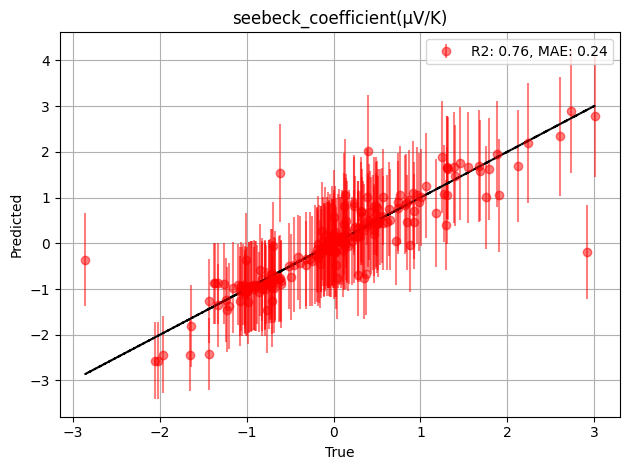

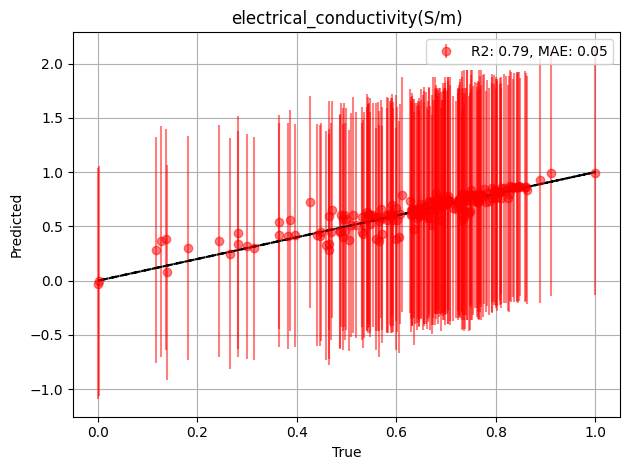

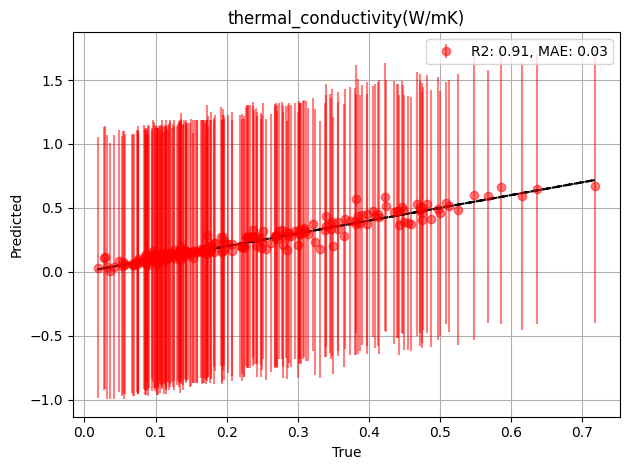

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

for prop, res in results.items():
    test_pred2 = res['test_pred']
    y_test2 = res['y_test']
    sigma2 = res['test_sigma']

    plt.figure()
    plt.errorbar(y_test2, test_pred2, yerr=sigma2, fmt='o', alpha=0.5, color='red',
                 label=f"R2: {r2_score(y_test2, test_pred2):.2f}, MAE: {mean_absolute_error(y_test2, test_pred2):.2f}")
    plt.plot(y_test2, y_test2, 'k--')
    plt.title(f"{prop}")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [26]:
# ------------------------------------------------------------------------------------------------ #

In [49]:
def predict_model(model, df_input, formula_col="Formula", temp_col="temperature(K)"):
    model.eval()
    model.to(model.compute_device)

    dataset = FormulaDataset(df_input, formula_col=formula_col, target_col=None)

    elem_list = []
    frac_list = []
    temp_list = []

    for elem, frac, temp in dataset:
        elem_list.append(elem)
        frac_list.append(frac)
        temp_list.append(temp)

    elem_tensor = torch.stack(elem_list).to(model.compute_device)
    frac_tensor = torch.stack(frac_list).to(model.compute_device)
    temp_tensor = torch.stack(temp_list).unsqueeze(1).to(model.compute_device)

    with torch.no_grad():
        output = model(elem_tensor, frac_tensor, temp_tensor)
        if output.ndim >= 2 and output.shape[1] >= 2:
            pred, logvar = output.chunk(2, dim=1)
            sigma = logvar.exp().sqrt()
        else:
            pred = output
            sigma = torch.zeros_like(pred)

    return pred.squeeze(-1).cpu().numpy(), sigma.squeeze(-1).cpu().numpy()

In [50]:
train_pred, train_sigma, test_pred, test_sigma = {}, {}, {}, {}

for prop in df1.columns[2:5]:
    model = results[prop]["model"]

    train_pred[prop], train_sigma[prop] = predict_model(model, df_train)
    test_pred[prop], test_sigma[prop] = predict_model(model, df_test)


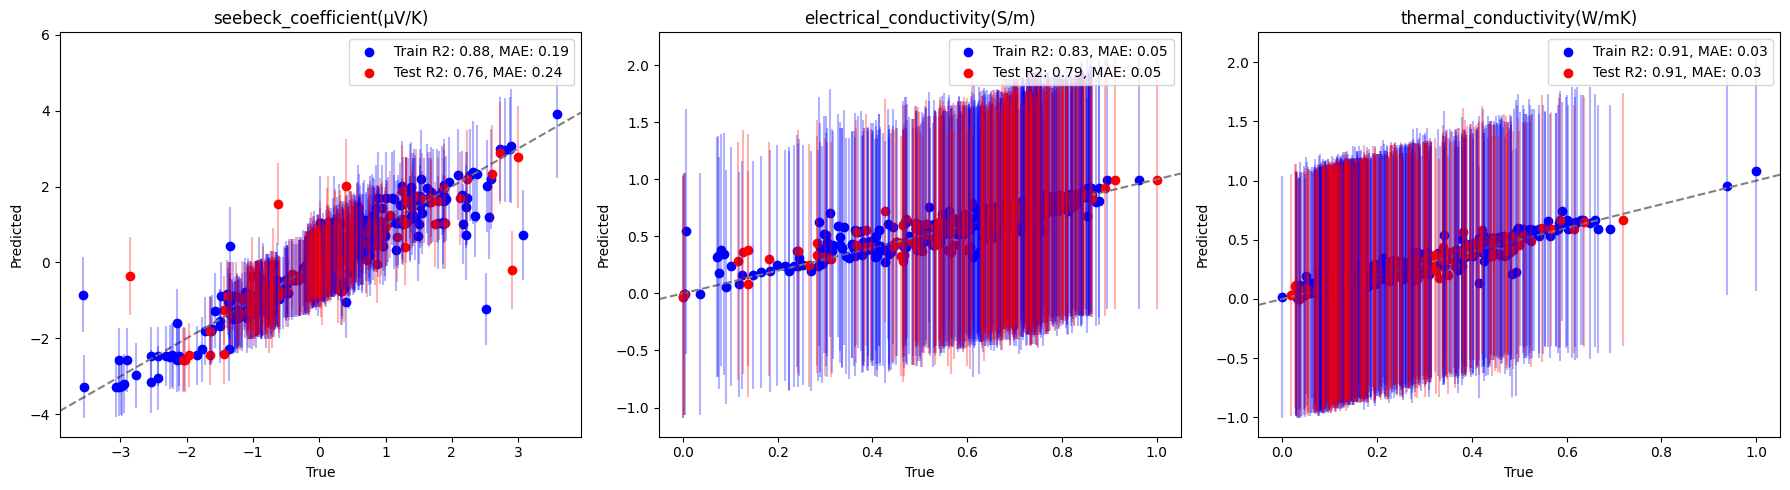

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))

for i, prop in enumerate(df1.columns[2:5]):
    # 결과에서 불러오기
    y_train = results[prop]['y_train']
    y_test = results[prop]['y_test']
    train_pred = results[prop]['train_pred']
    test_pred = results[prop]['test_pred']
    train_sigma = results[prop]['train_sigma']
    test_sigma = results[prop]['test_sigma']

    # 지표 계산
    r2_train = r2_score(y_train, train_pred)
    mae_train = mean_absolute_error(y_train, train_pred)

    r2_test = r2_score(y_test, test_pred)
    mae_test = mean_absolute_error(y_test, test_pred)

    # 시각화
    ax[i].axline((0, 0), slope=1, color='gray', linestyle='--')

    ax[i].scatter(y_train, train_pred, label=f'Train R2: {r2_train:.2f}, MAE: {mae_train:.2f}', color='blue')
    ax[i].errorbar(y_train, train_pred, yerr=train_sigma, fmt='none', color='blue', alpha=0.3)

    ax[i].scatter(y_test, test_pred, label=f'Test R2: {r2_test:.2f}, MAE: {mae_test:.2f}', color='red')
    ax[i].errorbar(y_test, test_pred, yerr=test_sigma, fmt='none', color='red', alpha=0.3)

    ax[i].set_title(prop)
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Predicted')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------- error bar 출력 제거 ---------------------------------------------------- #

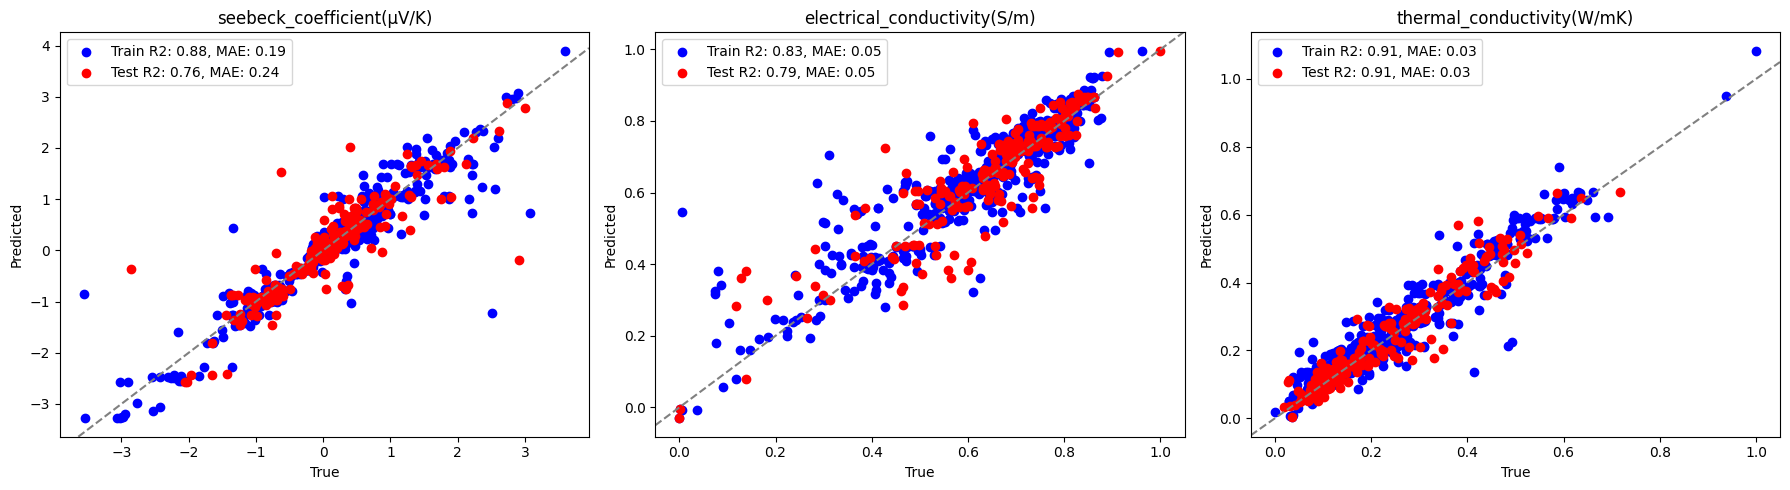

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))

for i, prop in enumerate(df1.columns[2:5]):
    y_train = results[prop]['y_train']
    y_test = results[prop]['y_test']
    train_pred = results[prop]['train_pred']
    test_pred = results[prop]['test_pred']

    r2_train = r2_score(y_train, train_pred)
    mae_train = mean_absolute_error(y_train, train_pred)

    r2_test = r2_score(y_test, test_pred)
    mae_test = mean_absolute_error(y_test, test_pred)

    ax[i].axline((0, 0), slope=1, color='gray', linestyle='--')

    ax[i].scatter(y_train, train_pred, label=f'Train R2: {r2_train:.2f}, MAE: {mae_train:.2f}', color='blue')
    ax[i].scatter(y_test, test_pred, label=f'Test R2: {r2_test:.2f}, MAE: {mae_test:.2f}', color='red')

    ax[i].set_title(prop)
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Predicted')
    ax[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------------------------------------------------------------------------- #

In [53]:
test_df22 = pd.DataFrame({
    "Formula": ["Bi2Te3"],
    "temperature(K)": [500]
})

# ✅ 온도 정규화 (학습 때 썼던 scaler_temp 사용)
test_df22["temperature(K)"] = scaler_temp.transform(test_df22[["temperature(K)"]])

# ✅ 예측 함수
def predict_single(model, df_input):
    model.eval()
    dataset = FormulaDataset(df_input, formula_col="Formula", target_col=None)

    elem_tensor, frac_tensor, temp_tensor = next(iter(dataset))  # 단일 샘플
    elem_tensor = elem_tensor.unsqueeze(0).to(model.compute_device)
    frac_tensor = frac_tensor.unsqueeze(0).to(model.compute_device)
    temp_tensor = temp_tensor.unsqueeze(0).to(model.compute_device)

    with torch.no_grad():
        output = model(elem_tensor, frac_tensor, temp_tensor)
        if output.shape[1] >= 2:
            pred, logvar = output.chunk(2, dim=1)
            sigma = logvar.exp().sqrt()
        else:
            pred = output
            sigma = torch.zeros_like(pred)

    return pred.squeeze().cpu().numpy(), sigma.squeeze().cpu().numpy()


In [54]:
for prop in ['seebeck_coefficient(μV/K)', 'electrical_conductivity(S/m)', 'thermal_conductivity(W/mK)']:
    model = results[prop]['model']
    pred, sigma = predict_single(model, test_df22)

    # 정규화 해제
    if prop in standard_cols:
        mean = df1[prop].mean()
        std = df1[prop].std(ddof=0)
        pred = pred * std + mean
        sigma = sigma * std
    elif prop in log_minmax_cols:
        raw = df1[prop].to_numpy()
        log_raw = np.log1p(raw)
        scaler = MinMaxScaler()
        scaler.fit(log_raw.reshape(-1, 1))
        log_val = scaler.inverse_transform([[pred]])[0][0]
        pred = np.expm1(log_val)
        sigma = None  # 정확한 역변환 어려움

    print(f"🔹 {prop} @ 500K = {pred:.4f} ± {sigma:.4f}" if sigma is not None else f"🔹 {prop} @ 500K ≈ {pred:.4f}")


🔹 seebeck_coefficient(μV/K) @ 500K = -124.4636 ± 184.3629
🔹 electrical_conductivity(S/m) @ 500K ≈ 117115.7644
🔹 thermal_conductivity(W/mK) @ 500K ≈ 1.1414
